In [15]:
# Copyright (c) 2024 Microsoft Corporation.
# Licensed under the MIT License

### with_graph_intelligence
#### init csv file

In [16]:
# our fake dataset
import asyncio
from pathlib import Path
import pandas as pd
import os
from graphrag.index.config import PipelineCSVInputConfig
from graphrag.index.input import load_input
init_dataset = pd.DataFrame([{"author": "aufsnn", 
                         "message": "Apple Inc. is an American multinational technology company headquartered in Cupertino, California. Tim Cook is the CEO of Apple.",
                         "date(yyyyMMddHHmmss)": "20240709182511"
                        },
                        {"author": "dmeck", 
                         "message": "hello!", 
                         "date(yyyyMMddHHmmss)": "20240709182511"}])

sample_data_dir = os.path.join(
    Path().cwd(), "input/"
)
if not os.path.exists(sample_data_dir):
    os.makedirs(sample_data_dir)
init_dataset.to_csv(f'{sample_data_dir}/dataset.csv', index=False)
sample_data_dir

'/media/gpt4-pdf-chatbot-langchain/graphrag/examples_notebooks/7_entity_extraction/with_graph_intelligence/input/'

In [17]:

shared_dataset = await load_input(
        PipelineCSVInputConfig(
            file_pattern=".*\\.csv$",
            base_dir=sample_data_dir,
            source_column="author",
            text_column="message",
            timestamp_column="date(yyyyMMddHHmmss)",
            timestamp_format="%Y%m%d%H%M%S",
            title_column="message",
        ),
    )
# We're cheap, and this is an example, lets just do 10
dataset = shared_dataset.head(10)
dataset

,author,message,date(yyyyMMddHHmmss),id,source,text,title,timestamp,year,month,day,hour,minute,second
0,aufsnn,Apple Inc. is an American multinational techno...,20240709182511,a9c886cbbc2905f65301a9215514ed0b,aufsnn,Apple Inc. is an American multinational techno...,Apple Inc. is an American multinational techno...,2024-07-09 18:25:11,2024,7,9,18,25,11
1,dmeck,hello!,20240709182511,409342b4e5e4bae7204236f4bf214055,dmeck,hello!,hello!,2024-07-09 18:25:11,2024,7,9,18,25,11


#### difine workflow   entity_extraction


In [18]:
# Copyright (c) 2024 Microsoft Corporation.
# Licensed under the MIT License
from graphrag.index.workflows import WorkflowDefinitions

custom_workflows: WorkflowDefinitions = {
    "entity_extraction": lambda config: [
        {
            "verb": "entity_extract",
            "args": {
                "column": "message",
                "id_column": "author",
                "async_mode": "asyncio",
                "strategy": config.get(
                    "strategy"
                ),
                "to": "entities",
                "graph_to": "entity_graph",
            },
        }
    ]
}


#### create pipeline workflows file

In [19]:
import pandas as pd
import os
from pathlib import Path

os.environ["EXAMPLE_OPENAI_API_KEY"] = os.environ.get("ZHIPUAI_API_KEY")

os.environ["EXAMPLE_OPENAI_API_BASE"] = 'https://open.bigmodel.cn/api/paas/v4'

os.environ["EXAMPLE_OPENAI_MODEL"] = 'glm-4'


os.environ["EXAMPLE_OPENAI_TEMPERATURE"] = '0.1'
os.environ["EXAMPLE_OPENAI_TOP_P"] = '0.9'


PIPELINE_YAML = """
workflows:
  - name: "entity_extraction"
    config: 
        strategy:
          type: "graph_intelligence"
          llm:
            type: "openai_chat"
    
            # create a .env file in the same directory as this pipeline.yml file
            # end add the following lines to it: 
            api_key: !ENV ${EXAMPLE_OPENAI_API_KEY:None} # None is the default
            api_base: !ENV ${EXAMPLE_OPENAI_API_BASE:None} # None is the default
            model: !ENV ${EXAMPLE_OPENAI_MODEL:gpt-3.5-turbo} # gpt-3.5-turbo is the default
            max_tokens: !ENV ${EXAMPLE_OPENAI_MAX_TOKENS:2500} # 2500 is the default
            temperature: !ENV ${EXAMPLE_OPENAI_TEMPERATURE:0} # 0 is the default
            top_p: !ENV ${EXAMPLE_OPENAI_TOP_P:1} # 1 is the default

 
"""
pipeline_file =  Path().cwd() / "pipeline.yaml"
with pipeline_file.open("w") as file:
    file.write(PIPELINE_YAML)
    

In [20]:
# Load your config without the input section
config_path = str(pipeline_file)
config_path

'/media/gpt4-pdf-chatbot-langchain/graphrag/examples_notebooks/7_entity_extraction/with_graph_intelligence/pipeline.yaml'

#### start pipeline entity_extraction workflow

Grab the last result from the pipeline, should be our entity extraction


In [21]:
from graphrag.index import run_pipeline_with_config

tables = []
async for table in run_pipeline_with_config(
    config_or_path=config_path, dataset=dataset,additional_workflows=custom_workflows
):
    tables.append(table)
pipeline_result = tables[-1]

# Print the entities.  This will be a row for each text unit, each with a list of entities,
# This should look pretty close to the python version, but since we're using an LLM
# it will be a little different depending on how it feels about the text
if pipeline_result.result is not None:
    print(pipeline_result.result["entities"].to_list())
else:
    print("No results!")

[[{'name': '"APPLE INC."', 'type': '"ORGANIZATION"', 'description': '"Apple Inc. is a multinational technology company with its headquarters in Cupertino, California."', 'source_id': 'aufsnn'}, {'name': '"TIM COOK"', 'type': '"PERSON"', 'description': '"Tim Cook is the CEO of Apple Inc., indicating he is a key figure within the organization."', 'source_id': 'aufsnn'}, {'name': '"CUPERTINO, CALIFORNIA"', 'type': '"GEO"', 'description': '"Cupertino, California is the location of the headquarters for Apple Inc."', 'source_id': 'aufsnn'}], [{'name': '"HELLO!"', 'type': '"CONCEPT"', 'description': '"hello! is an exclamation of greeting or attention, though not fitting the provided entity types, it is the only distinct element in the text."', 'source_id': 'dmeck'}]]


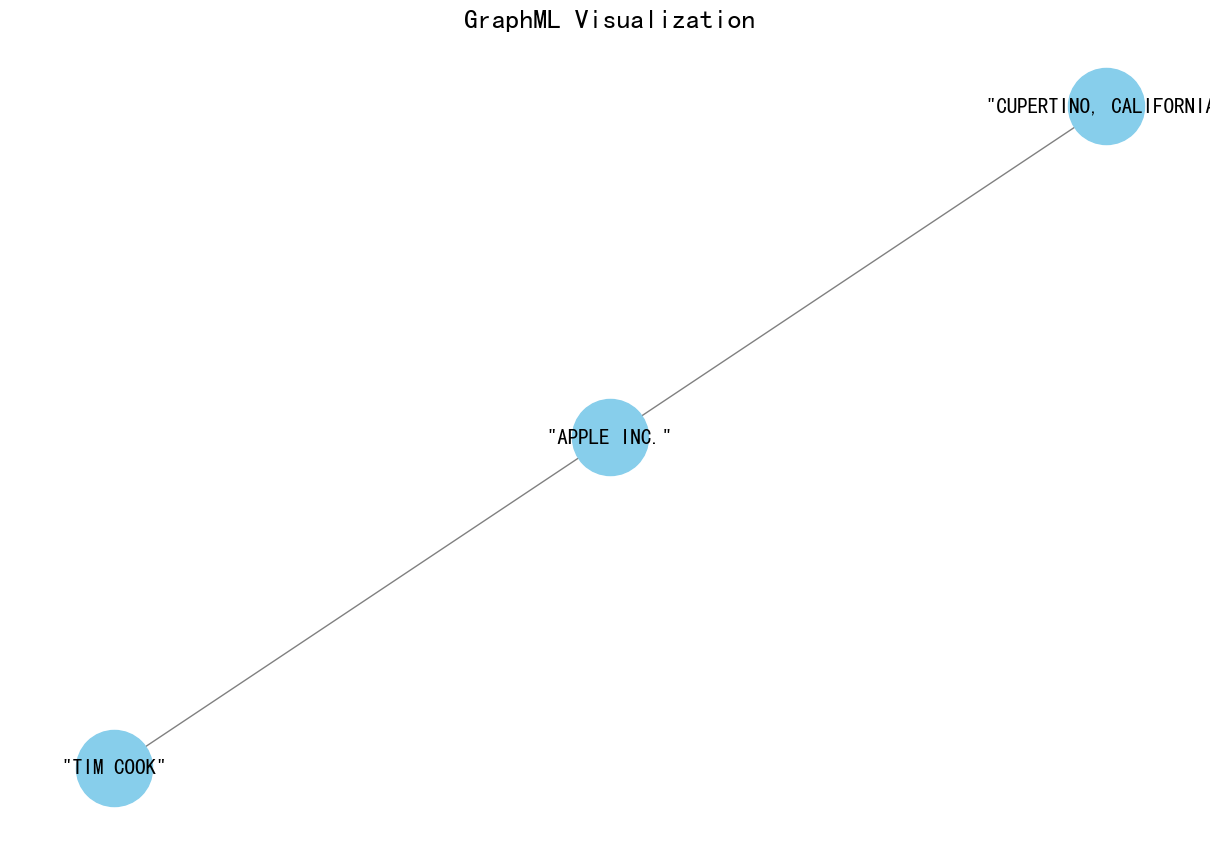

In [4]:
import matplotlib.pyplot as plt
from typing import Any, cast
import os
from pathlib import Path
import networkx as nx
import pandas as pd
from graphrag.index.utils import load_graph
from matplotlib import rcParams
import matplotlib.font_manager as fm

output_data_dir = os.path.join(
    Path().cwd(), "output/"
)

report_df = pd.read_parquet(f"{output_data_dir}/entity_extraction.parquet")

G = load_graph(cast(str | nx.Graph, report_df['entity_graph'][0]))

 # Set the font properties
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['SimHei']  # Use 'Noto Sans CJK' or another font that supports Chinese characters

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='skyblue', node_size=3000, edge_color='gray', font_size=15, font_weight='bold')
plt.title('GraphML Visualization', size=20)
plt.show()
